# Real vs Fake faces images Classifier

## Subject
Deepfakes are a type of technology in the Artificial Intelligence field that consists of generating realistic images, audio, and videos of persons using Machine Learning.
Although some of the generated content can be easily distinguishable from real materials, some of them prove to be difficult to spot as artificial content.

## Goal
This project aims to build an image classifier able to classify images of faces into two classes: real and fake (generated by artificial intelligence).

## Data
The dataset used for this project can be accessed at: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k

In [189]:
import PIL
import PIL.Image as Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import os
import math

In [190]:
# Extracting the test and validation data from their respective folders
trainData = list()
validationData = list()
imgsPath = '/kaggle/input/rvf10k/rvf10k'

for dataFolder in os.listdir(imgsPath):
    for dataLabel in os.listdir(imgsPath+'/'+dataFolder):
        for imName in os.listdir(imgsPath+'/'+dataFolder+'/'+dataLabel):
            imPath = imgsPath+'/'+dataFolder+'/'+dataLabel+'/'+imName
            if dataFolder == 'train':
                if dataLabel == 'fake':
                    trainData.append((Image.open(imPath), 'fake'))
                else:
                    trainData.append((Image.open(imPath), 'real'))
            else:
                if dataLabel == 'fake':
                    validationData.append((Image.open(imPath), 'fake'))
                else:
                    validationData.append((Image.open(imPath), 'real'))

# Looking at data
Now that we have all the images that we'll use to train the model, let's take a look at some of the samples of each class (fake or real)

Num Real Samples: 3500
Num Fake samples: 3500


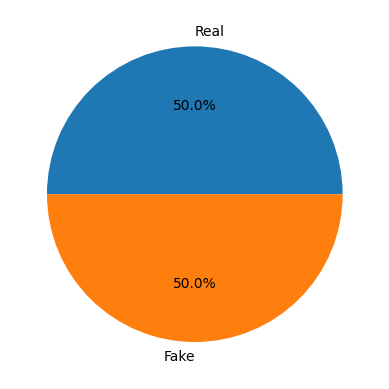

In [191]:
# Counting num. of samples of each class in training data
numReal = 0
numFake = 0


for sample in trainData:
    numReal += np.sum(sample[1] == 'real')
    numFake += np.sum(sample[1] == 'fake')

print(f'Num Real Samples: {numReal}\nNum Fake samples: {numFake}')
plt.pie([numReal, numFake], labels=['Real', 'Fake'], autopct='%1.1f%%')
plt.show()

In [192]:
# Checking shape of images

print(np.unique([sample[0].size for sample in trainData]))
print(np.unique([sample[0].size for sample in validationData]))

# All images have the shape (256, 256)

[256]
[256]


In [193]:
# Function to display N random sample images given its label (fake or real)
def showRandomImgs(data=trainData, imgs=5, label='fake', cols=5):
    rows = math.ceil(imgs / cols)
    images = list()
    cont = 0
    while True:
        if cont == imgs:
            break
        randImg = random.choice(data)
        if randImg[1] == label:  
            images.append(randImg[0])
            cont += 1

    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    indexImages = 0
    for r in range(rows):
        for c in range(cols):
            if indexImages == imgs:
                break
            if rows > 1:
                ax[r][c].imshow(images[indexImages])
                ax[r][c].axis('off')
                indexImages += 1
            else:
                ax[c].imshow(images[indexImages])
                ax[c].axis('off')
                indexImages += 1

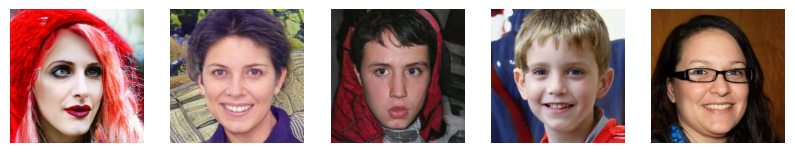

In [194]:
# Looking at 5 random training images labeled as "fake"
showRandomImgs(imgs=5, label='fake')

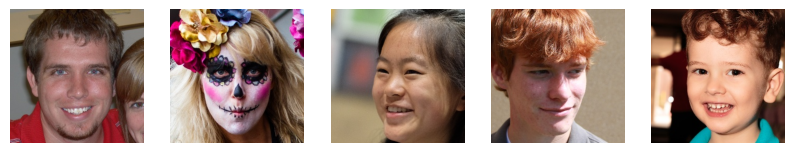

In [195]:
# Looking at 5 random training images labeled as "real"
showRandomImgs(imgs=5, label='real')

In [196]:
# Building Train Dataset Class
class TrainFaceDataset(Dataset):
    def __init__(self, trainData, transforms=None):
        self.trainData = trainData
        self.len = len(trainData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.trainData[index][0]
        label = 0 if self.trainData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

In [197]:
# Building Validation Dataset Class
class ValidationFaceDataset(Dataset):
    def __init__(self, validationData, transforms=None):
        self.validationData = validationData
        self.len = len(validationData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.validationData[index][0]
        label = 0 if self.validationData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

# Transforming images

Let's use some transformations on the data:
- Normalize both training and validation data
- Flip Horizontally the image (probability of 50%)

In [198]:
trainTransformsComposed = transforms.Compose([transforms.ToTensor(), 
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                              transforms.RandomHorizontalFlip(p=0.5)])

validationTransformsComposed = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataset = TrainFaceDataset(trainData, transforms=trainTransformsComposed)
validationDataset = ValidationFaceDataset(validationData, transforms=validationTransformsComposed)

# Building CNN

In [199]:
class CNN(nn.Module):
    def __init__(self, input_dim=3, out_1=32, out_2=64, out_3=128, out_4=256, out_5=512):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=out_1, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(out_1)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(out_2)
        self.conv3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, padding=2)
        self.bn3 = nn.BatchNorm2d(out_3)
        self.conv4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm2d(out_4)
        self.conv5 = nn.Conv2d(in_channels=out_4, out_channels=out_5, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(out_5)
        self.fc1 = nn.Linear(512 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 4096)
        self.fc5 = nn.Linear(4096, 2)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x

In [200]:
# Checking if GPU is avaible to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU?', torch.cuda.is_available())

GPU? True


In [201]:
model = CNN()

In [202]:
model = model.to(device)

In [203]:
batch_size = 4
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=True)

# Defining Hyper parameters for training

In [204]:
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50

In [205]:
def trainModel(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    results = {'costs': list(), 'accuracy': list()}
    for epoch in range(epochs):
        cost = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            cost += loss.item()
            optimizer.step()
            
        cost = cost / len(train_loader)
        
        accuracy = validateModel(model, validation_loader)['accuracy']
        results['accuracy'].append(accuracy.cpu())
        results['costs'].append(cost)
        print(f'Epoch: {epoch+1}/{epochs}\nLoss: {cost}\nAccuracy: {accuracy * 100:.2f}%\n____________________')
        
    return results

In [206]:
def validateModel(model, validation_loader):
    model.eval()
    validation_results = {'accuracy': 0, 'pred_labels': list(), 'true_labels': list()}
    correct = 0
    with torch.no_grad():
        for x, y in validation_loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            
            _, label = y_hat.max(1)
            validation_results['pred_labels'].extend(label.cpu().numpy())
            validation_results['true_labels'].extend(y.cpu().numpy())
            correct += (label == y).sum()
        
    validation_results['accuracy'] = correct / len(validationDataset)
    model.train()
    return validation_results

# Training model

In [207]:
training_results = trainModel(model, train_loader, criterion, optimizer, num_epochs)

Epoch: 1/50
Loss: 0.6983046065228325
Accuracy: 61.70%
____________________
Epoch: 2/50
Loss: 0.6727634693895067
Accuracy: 64.17%
____________________
Epoch: 3/50
Loss: 0.6469086295877184
Accuracy: 67.23%
____________________
Epoch: 4/50
Loss: 0.6183756389107024
Accuracy: 71.37%
____________________
Epoch: 5/50
Loss: 0.5848578132710287
Accuracy: 71.67%
____________________
Epoch: 6/50
Loss: 0.5547383063648428
Accuracy: 74.03%
____________________
Epoch: 7/50
Loss: 0.5217511763423681
Accuracy: 75.03%
____________________
Epoch: 8/50
Loss: 0.4976693401560187
Accuracy: 75.93%
____________________
Epoch: 9/50
Loss: 0.469998927586845
Accuracy: 79.53%
____________________
Epoch: 10/50
Loss: 0.4422208455407194
Accuracy: 78.30%
____________________
Epoch: 11/50
Loss: 0.40899230587535673
Accuracy: 80.83%
____________________
Epoch: 12/50
Loss: 0.38989810740934416
Accuracy: 81.87%
____________________
Epoch: 13/50
Loss: 0.3558489856102637
Accuracy: 81.10%
____________________
Epoch: 14/50
Loss: 0

# Analyzing training results

In [208]:
def plotCostAccuracy(costs, accuracy):
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.plot(costs, color=color)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    
    ax2 = ax1.twinx()
    color = 'blue'
    ax2.plot(accuracy, color=color)
    ax2.set_ylabel('Accuracy', color=color)

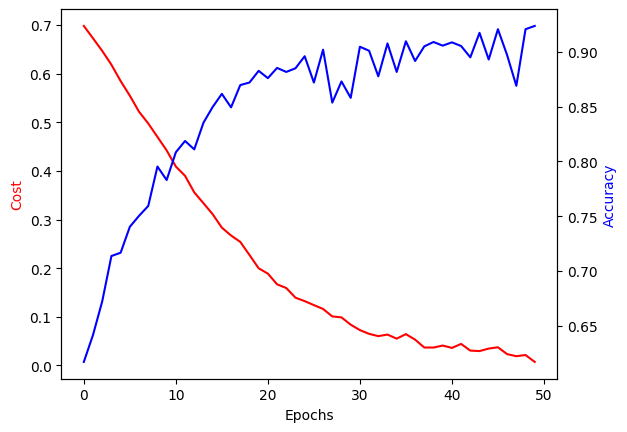

In [209]:
# Let's plot a graph containing the info about Cost and Accuracy of the model
plotCostAccuracy(training_results['costs'], training_results['accuracy'])

In [210]:
def plotConfusionMatrix(model=model, validation_loader=validation_loader):
    validation_results = validateModel(model, validation_loader)
    pred_labels = validation_results['pred_labels']
    true_labels = validation_results['true_labels']      
    
    confusion_mtx = confusion_matrix(y_pred=pred_labels, y_true=true_labels)
    disp = ConfusionMatrixDisplay(confusion_mtx, display_labels=['Real', 'Fake'])
    disp.plot()

In [211]:
def plotMissClassified(model=model, validation_dataset=validationDataset, num_examples=5):
    cont = 0
    for x, y in DataLoader(validation_dataset, batch_size=1, shuffle=True):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        _, predLabel = y_hat.max(1)
        if (predLabel != y):
            cont += 1
            fig, ax = plt.subplots(figsize=(3, 3))
            ax.imshow(x.cpu().permute(2, 3, 1, 0).squeeze())
            plt.title(f'True Label: {"Fake" if y.cpu().item() == 1 else "Real"} | Predicted Label: {"Fake" if predLabel == 1 else "Real"}')
            plt.show()
        if cont == num_examples:
            break

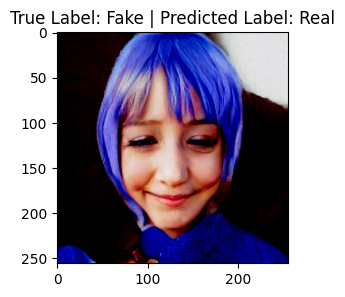

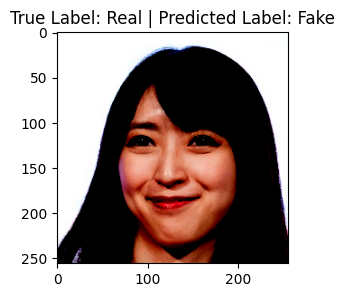

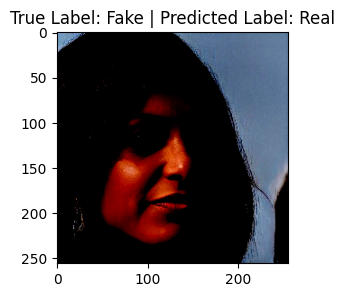

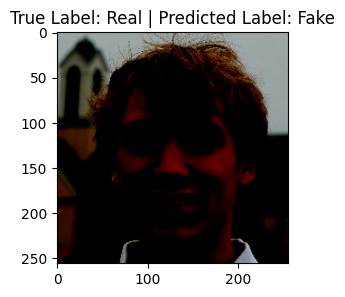

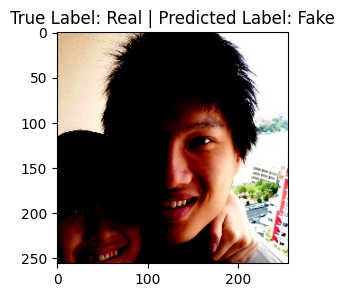

In [212]:
# Let's plot some examples of missclassifed images
plotMissClassified()

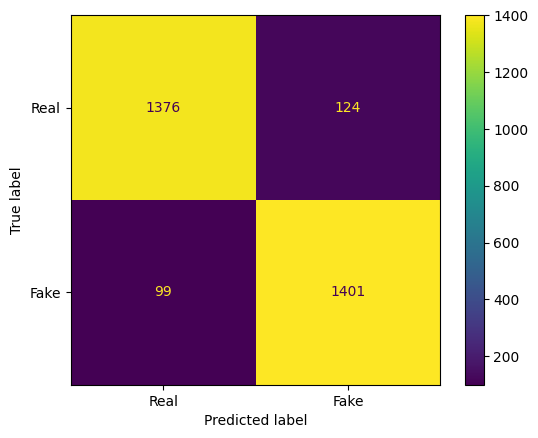

In [213]:
# Let's plot the confusion matrix
plotConfusionMatrix()